### Model Training / Обучение моделей
1. Разбиение выборки на тренировочную и тестовую
2. Построение пайплайнов моделей
3. Определение гиперпараметров
4. Кроссвалидация и настройка гиперпараметров
5. Оценка метрик качества модели и выбор модели-победителя

Рассматриваемые модели:
Elastic Net, Ridge Regression, Lasso Regression, Random Forest и Gradient Boosted Trees

In [5]:
import sqlite3
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import ElasticNet, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.exceptions import NotFittedError
import pickle

In [6]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [7]:
conn = sqlite3.connect('db\cian.db') 
          
df = pd.read_sql_query ('''
                               SELECT *
                               FROM analytical_base_table
                               ''', conn)

1. Разбиение выборки на тренировочную и тестовую

In [7]:
# создание выходной (целевой) переменной
y = df.price
# создание входных переменных
X = df.drop('price', axis = 1)

In [8]:
# разбиение выбоки на тренировочную и тестовую в пропорции 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [15]:
# размеры выборок
print(f"Размеры выборок \nX_train: {len(X_train)},\nX_test: {len(X_test)},\ny_train: {len(y_train)},\ny_test: {len(y_test)}")

Размеры выборок 
X_train: 66925,
X_test: 16732,
y_train: 66925,
y_test: 16732


2. Построение пайплайнов моделей

In [16]:
# Описательные статистики X_train
X_train.describe().round(1)

,rooms,mortgage,area,living_area,kitchen_area,floor,floors,ceiling_height,is_suspicious,property_age,...,heating_индивидуальный тепловой пункт,heating_котел/квартирное отопление,heating_центральное,interior_design_без ремонта,interior_design_дизайнерский,interior_design_евроремонт,interior_design_косметический,interior_design_пропущено,interior_design_черновой,interior_design_чистовой
count,66925.0,66925.0,66925.0,66925.0,66925.0,66925.0,66925.0,66925.0,66925.0,66925.0,...,66925.0,66925.0,66925.0,66925.0,66925.0,66925.0,66925.0,66925.0,66925.0,66925.0
mean,1.9,0.8,69.7,39.2,12.8,9.5,18.8,2.8,0.0,18.5,...,0.0,0.0,1.0,0.2,0.1,0.1,0.2,0.3,0.0,0.1
std,1.1,0.4,51.2,32.6,7.3,8.5,12.1,0.3,0.0,26.7,...,0.1,0.0,0.2,0.4,0.3,0.3,0.4,0.4,0.2,0.3
min,-1.0,0.0,10.0,6.0,0.6,-1.0,1.0,2.4,0.0,-4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,1.0,1.0,41.0,20.2,8.3,3.0,10.0,2.6,0.0,-1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,2.0,1.0,57.3,31.3,10.9,7.0,16.0,2.7,0.0,4.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,3.0,1.0,79.0,45.6,15.9,13.0,24.0,3.0,0.0,38.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
max,6.0,1.0,993.6,650.0,240.0,94.0,120.0,12.0,1.0,240.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


Стандартизация данных

In [17]:
# стандартизация X_train
X_train_new = (X_train - X_train.mean())/X_train.std()

In [18]:
# описательная статистика для стандартизированных тренировочных данных
X_train_new.describe().round(1)

,rooms,mortgage,area,living_area,kitchen_area,floor,floors,ceiling_height,is_suspicious,property_age,...,heating_индивидуальный тепловой пункт,heating_котел/квартирное отопление,heating_центральное,interior_design_без ремонта,interior_design_дизайнерский,interior_design_евроремонт,interior_design_косметический,interior_design_пропущено,interior_design_черновой,interior_design_чистовой
count,66925.0,66925.0,66925.0,66925.0,66925.0,66925.0,66925.0,66925.0,66925.0,66925.0,...,66925.0,66925.0,66925.0,66925.0,66925.0,66925.0,66925.0,66925.0,66925.0,66925.0
mean,-0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,...,0.0,-0.0,0.0,-0.0,0.0,-0.0,-0.0,-0.0,0.0,-0.0
std,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
min,-2.6,-2.1,-1.2,-1.0,-1.7,-1.2,-1.5,-1.2,-0.0,-0.8,...,-0.1,-0.0,-6.0,-0.5,-0.3,-0.4,-0.5,-0.6,-0.2,-0.4
25%,-0.8,0.5,-0.6,-0.6,-0.6,-0.8,-0.7,-0.6,-0.0,-0.7,...,-0.1,-0.0,0.2,-0.5,-0.3,-0.4,-0.5,-0.6,-0.2,-0.4
50%,0.0,0.5,-0.2,-0.2,-0.3,-0.3,-0.2,-0.3,-0.0,-0.5,...,-0.1,-0.0,0.2,-0.5,-0.3,-0.4,-0.5,-0.6,-0.2,-0.4
75%,0.9,0.5,0.2,0.2,0.4,0.4,0.4,0.7,-0.0,0.7,...,-0.1,-0.0,0.2,-0.5,-0.3,-0.4,-0.5,1.7,-0.2,-0.4
max,3.5,0.5,18.0,18.7,31.3,9.9,8.4,28.5,39.4,8.3,...,7.7,30.7,0.2,2.0,3.0,2.6,2.2,1.7,5.4,2.8


In [19]:
# создание словаря pipelines для алгоритмов Elastic Net, Ridge Regression и Lasso Regression
pipelines =  {
            'lasso': make_pipeline(StandardScaler(), Lasso(random_state=123)),
            'ridge': make_pipeline(StandardScaler(), Ridge(random_state=123)),
            'enet': make_pipeline(StandardScaler(), ElasticNet(random_state=123))
                }

In [20]:
# добавление в словарь pipeline для RandomForestRegressor (rf) и GradientBoostingRegressor (gb)
pipelines['rf'] = make_pipeline(StandardScaler(), RandomForestRegressor(random_state=123))
pipelines['gb'] = make_pipeline(StandardScaler(),
                                GradientBoostingRegressor(random_state=123 ))

In [21]:
# проверка наличия pipeline для каждого алгоритма
for key, value in pipelines.items():
    print( key, type(value) )

lasso <class 'sklearn.pipeline.Pipeline'>
ridge <class 'sklearn.pipeline.Pipeline'>
enet <class 'sklearn.pipeline.Pipeline'>
rf <class 'sklearn.pipeline.Pipeline'>
gb <class 'sklearn.pipeline.Pipeline'>


3. Определение гиперпараметров

In [22]:
# список настраиваемых гиперпараметров для Lasso pipeline
pipelines['lasso'].get_params()

{'memory': None,
 'steps': [('standardscaler', StandardScaler()),
  ('lasso', Lasso(random_state=123))],
 'verbose': False,
 'standardscaler': StandardScaler(),
 'lasso': Lasso(random_state=123),
 'standardscaler__copy': True,
 'standardscaler__with_mean': True,
 'standardscaler__with_std': True,
 'lasso__alpha': 1.0,
 'lasso__copy_X': True,
 'lasso__fit_intercept': True,
 'lasso__max_iter': 1000,
 'lasso__normalize': 'deprecated',
 'lasso__positive': False,
 'lasso__precompute': False,
 'lasso__random_state': 123,
 'lasso__selection': 'cyclic',
 'lasso__tol': 0.0001,
 'lasso__warm_start': False}

In [23]:
# гиперпараметры Lasso 
lasso_hyperparameters = {'lasso__alpha':[0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10] }

# гиперпараметры Ridge 
ridge_hyperparameters = {'ridge__alpha': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10] }

In [24]:
# гиперпараметры Elastic Net
enet_hyperparameters = {
    'elasticnet__alpha': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10],
    'elasticnet__l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
    }

In [25]:
# гиперпараметры Random forest
rf_hyperparameters  = {
    'randomforestregressor__n_estimators': [100,200],
    'randomforestregressor__max_features': ['log2', 'sqrt', 1.0, 0.33]
}

In [26]:
# гиперпараметры Boosted tree
gb_hyperparameters = {
            'gradientboostingregressor__n_estimators' : [100,200],
            'gradientboostingregressor__learning_rate': [0.05, 0.1,0.2],
            'gradientboostingregressor__max_depth': [1,3,5]
}

In [27]:
# словарь гиперпараметров для всех моделей
hyperparameters = {
    'rf': rf_hyperparameters,
    'gb': gb_hyperparameters,
    'lasso': lasso_hyperparameters,
    'ridge': ridge_hyperparameters,
    'enet': enet_hyperparameters
}

In [28]:
# проверка
for key in ['enet', 'gb', 'ridge', 'rf', 'lasso']:
    if key in hyperparameters:
        if type(hyperparameters[key]) is dict:
            print( key, 'есть в hyperparameters, и это словарь' )
        else:
            print( key, 'есть в hyperparameters, но это не словарь' )
    else:
        print( key, 'нет в hyperparameters')

enet есть в hyperparameters, и это словарь
gb есть в hyperparameters, и это словарь
ridge есть в hyperparameters, и это словарь
rf есть в hyperparameters, и это словарь
lasso есть в hyperparameters, и это словарь


4. Кроссвалидация и настройка гиперпараметров

In [33]:
# создание словаря обученных моделей
fitted_models = {}

# проход по всем пайплайнам моделей, обучение каждой модели и сохранение обученной модели в словарь
for name, pipeline in pipelines.items():
    # создание модели - объекта кросс-валидации
    model = GridSearchCV(pipeline, hyperparameters[name], cv = 10, n_jobs=-1)
    
    # обучение модели на X_train, y_train
    model.fit(X_train, y_train)
    
    # сохранение обученной модели в fitted_models[name] 
    fitted_models[name] = model

    print(f"модель {name} обучена")

c:\Users\T-1000\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.316e+18, tolerance: 1.920e+16
  model = cd_fast.enet_coordinate_descent(


модель lasso обучена
модель ridge обучена


c:\Users\T-1000\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.355e+19, tolerance: 1.920e+16
  model = cd_fast.enet_coordinate_descent(


модель enet обучена
модель rf обучена
модель gb обучена


In [34]:
# проверка на наличие всех 5 моделей
for key, value in fitted_models.items():
    print( key, type(value) )

lasso <class 'sklearn.model_selection._search.GridSearchCV'>
ridge <class 'sklearn.model_selection._search.GridSearchCV'>
enet <class 'sklearn.model_selection._search.GridSearchCV'>
rf <class 'sklearn.model_selection._search.GridSearchCV'>
gb <class 'sklearn.model_selection._search.GridSearchCV'>


In [35]:
# проверка на NotFittedError
for name, model in fitted_models.items():
    try:
        pred = model.predict(X_test)
        print(name, 'has been fitted.')
    except NotFittedError as er:
        print(repr(er))

lasso has been fitted.
ridge has been fitted.
enet has been fitted.
rf has been fitted.
gb has been fitted.


 5. Оценка метрик качества модели и выбор модели-победителя

In [36]:
from sklearn.metrics import r2_score, mean_absolute_error

In [37]:
# r2_score и MAE для каждой модели
for name, model in fitted_models.items():
    print(name)
    print('--------')
    pred = model.predict(X_test)
    print('R^2:', r2_score(y_test, pred))
    print('MAE: ', mean_absolute_error(y_test, pred))
    print('\n')

lasso
--------
R^2: 0.7699619713828405
MAE:  11079312.780976089


ridge
--------
R^2: 0.7699956093345947
MAE:  11074965.995678749


enet
--------
R^2: 0.770157807308262
MAE:  11051265.767094688


rf
--------
R^2: 0.9004336164096878
MAE:  4701742.784076227


gb
--------
R^2: 0.8864904038765938
MAE:  5712831.940614481




Наибольшее значение R^2 и наименьшее значение MAE имеет один и тот же алгоритм - Random Forest.
Random Forest - наиболее эффективная модель для предсказание цен на квартиры в Москве среди пяти рассмотренных моделей.

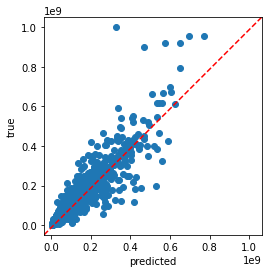

In [28]:
# точечный график истинных и предсказанных значений
rf_pred = fitted_models['rf'].predict(X_test)
f, ax = plt.subplots(1)
ax.scatter(rf_pred, y_test)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, color='r', ls='--')
plt.xlabel('predicted')
plt.ylabel('true')
plt.axis('square')
plt.show(f)

Большинство точек на графике сконцентрировано около диагонали, исключение составляют точки-выбросы (квартиры с очень высокой стоимостью).

In [47]:
# гиперпараметры лучшей модели
fitted_models['rf'].best_params_

{'randomforestregressor__max_features': 1.0,
 'randomforestregressor__n_estimators': 200}

In [51]:
# сохранение всех моделей
with open('fitted_models/lasso_model.pkl', 'wb') as f:
    pickle.dump(fitted_models['lasso'].best_estimator_, f)

with open('fitted_models/ridge_model.pkl', 'wb') as f:
    pickle.dump(fitted_models['ridge'].best_estimator_, f)

with open('fitted_models/enet_model.pkl', 'wb') as f:
    pickle.dump(fitted_models['enet'].best_estimator_, f)

with open('fitted_models/rf_model.pkl', 'wb') as f:
    pickle.dump(fitted_models['rf'].best_estimator_, f)

with open('fitted_models/gb_model.pkl', 'wb') as f:
    pickle.dump(fitted_models['gb'].best_estimator_, f)

ИТОГ: Среди пяти рассмотренных моделей: Elastic Net, Ridge Regression, Lasso Regression, Random Forest и Gradient Boosted Trees - наилучшую эффективность пооказала модель Random Forest с числом решающих деревьев, равным 200, и с количеством признаков, учитываемых при поиске лучшего сплита, равном общему числу признаков (max_features=n_features).